In [3]:
import tkinter as tk
from tkinter import filedialog
import os

def select_excel_file():
    """Opens a file dialog to select an Excel file"""
    root = tk.Tk()
    root.withdraw()
    
    # Force window to front
    root.attributes('-topmost', True)
    root.update()
    
    file_path = filedialog.askopenfilename(
        parent=root,
        title="Select FTIR Excel file",
        filetypes=[
            ("Excel files", "*.xlsx *.xls *.xlsm"),
            ("All files", "*.*")
        ],
        initialdir=os.getcwd()
    )
    
    root.destroy()
    
    return file_path

# Usage
file_path = select_excel_file()
if file_path:
    print(f"Selected file: {file_path}")
else:
    print("No file selected")

Selected file: C:/Users/Talaial Alina/OneDrive - UCB-O365/Courses/Year 1/Fall Semester Aug-Dec 2020/CHEN 5840 - Independent Study/Hydrogels/FTIR/21MAY25/Compiled_CSV_Files.xlsx


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.stats import ttest_ind
from scipy import interpolate
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output

# Global storage
processed_spectra = {}

def interactive_baseline_correction(df, sheet_name):
    """Your baseline correction function"""
    baseline_points = []
    output = widgets.Output()
    
    fig = go.FigureWidget()
    
    fig.add_trace(go.Scatter(
        x=df['Wavenumber'], 
        y=df['Absorbance'],
        mode='lines',
        name='Original Spectrum',
        line=dict(color='blue', width=2)
    ))
    
    fig.add_trace(go.Scatter(
        x=[], y=[],
        mode='markers',
        name='Baseline Points',
        marker=dict(color='red', size=10, symbol='circle')
    ))
    
    fig.add_trace(go.Scatter(
        x=[], y=[],
        mode='lines',
        name='Baseline',
        line=dict(color='green', width=2, dash='dash')
    ))
    
    fig.add_trace(go.Scatter(
        x=[], y=[],
        mode='lines',
        name='Baseline Subtracted',
        line=dict(color='purple', width=2),
        visible=False
    ))
    
    fig.update_layout(
        title=f'{sheet_name} - Click to select baseline points',
        xaxis_title='Wavenumber (cm⁻¹)',
        yaxis_title='Absorbance',
        height=600,
        width=1000,
        hovermode='closest',
        xaxis=dict(autorange='reversed')
    )
    
    generate_button = widgets.Button(description="Generate Baseline")
    apply_button = widgets.Button(description="Apply Baseline")
    clear_button = widgets.Button(description="Clear Points")
    done_button = widgets.Button(description="Done & Save", button_style='success')
    
    baseline_info = {}
    
    def on_click(trace, points, selector):
        try:
            if not points.xs or len(points.xs) == 0:
                return
            
            x, y = points.xs[0], points.ys[0]
            baseline_points.append((x, y))
            
            x_vals = [point[0] for point in baseline_points]
            y_vals = [point[1] for point in baseline_points]
            
            with fig.batch_update():
                fig.data[1].x = x_vals
                fig.data[1].y = y_vals
            
            output.clear_output()
            with output:
                print(f"Added point: Wavenumber={x:.1f}, Absorbance={y:.4f}")
                print(f"Total points: {len(baseline_points)}")
        except Exception as e:
            pass
    
    fig.data[0].on_click(on_click)
    
    def generate_baseline(b):
        if len(baseline_points) < 2:
            output.clear_output()
            with output:
                print("Need at least 2 points to generate baseline!")
            return
        
        sorted_points = sorted(baseline_points, key=lambda p: p[0])
        x_points = np.array([p[0] for p in sorted_points])
        y_points = np.array([p[1] for p in sorted_points])
        
        if len(x_points) >= 4:
            f = interpolate.interp1d(x_points, y_points, kind='cubic', 
                                   bounds_error=False, fill_value='extrapolate')
        else:
            f = interpolate.interp1d(x_points, y_points, kind='linear',
                                   bounds_error=False, fill_value='extrapolate')
        
        baseline_y = f(df['Wavenumber'])
        baseline_info['baseline_y'] = baseline_y
        
        with fig.batch_update():
            fig.data[2].x = df['Wavenumber']
            fig.data[2].y = baseline_y
        
        output.clear_output()
        with output:
            print("Baseline generated!")
    
    def apply_baseline(b):
        if 'baseline_y' not in baseline_info:
            output.clear_output()
            with output:
                print("Generate baseline first!")
            return
        
        baseline_y = baseline_info['baseline_y']
        corrected_absorbance = df['Absorbance'] - baseline_y
        baseline_info['corrected'] = corrected_absorbance
        
        with fig.batch_update():
            fig.data[3].x = df['Wavenumber']
            fig.data[3].y = corrected_absorbance
            fig.data[3].visible = True
        
        # AUTOMATICALLY SAVE when baseline is applied
        df_corrected = df.copy()
        df_corrected['Absorbance'] = corrected_absorbance
        df_corrected['Original_Absorbance'] = df['Absorbance']
        df_corrected['Baseline'] = baseline_y
        
        processed_spectra[sheet_name] = df_corrected
        
        output.clear_output()
        with output:
            print("✓ Baseline applied and saved!")
            print(f"Corrected spectrum saved for {sheet_name}")
            print("\nClick 'Process Next Spectrum' to continue")

    
    def save_and_close(b):
        if 'corrected' in baseline_info:
            df_corrected = df.copy()
            df_corrected['Absorbance'] = baseline_info['corrected']
            df_corrected['Original_Absorbance'] = df['Absorbance']
            df_corrected['Baseline'] = baseline_info['baseline_y']
            
            processed_spectra[sheet_name] = df_corrected
            
            output.clear_output()
            with output:
                print(f"✓ Saved corrected spectrum for {sheet_name}")
                done_button.button_style = 'info'
        else:
            processed_spectra[sheet_name] = df
            output.clear_output()
            with output:
                print(f"✓ Saved original spectrum for {sheet_name}")
    
    def clear_points(b):
        baseline_points.clear()
        baseline_info.clear()
        
        with fig.batch_update():
            fig.data[1].x = []
            fig.data[1].y = []
            fig.data[2].x = []
            fig.data[2].y = []
            fig.data[3].x = []
            fig.data[3].y = []
            fig.data[3].visible = False
        
        output.clear_output()
        with output:
            print("All points cleared.")
    
    generate_button.on_click(generate_baseline)
    apply_button.on_click(apply_baseline)
    clear_button.on_click(clear_points)
    done_button.on_click(save_and_close)
    
    instructions = widgets.HTML(
        "<b>Instructions:</b><br>"
        "1. Click on spectrum to select baseline points<br>"
        "2. Generate → Apply → Done & Save<br>"
    )
    
    button_box = widgets.HBox([generate_button, apply_button, clear_button])
    
    display(widgets.VBox([
        instructions,
        fig,
        button_box,
        output
    ]))

def process_sheet(sheet_name, xls, start_row=39):
    """Load and process a single sheet"""
    df = pd.read_excel(xls, sheet_name=sheet_name, skiprows=start_row, usecols="A:B")
    df.columns = ['Wavenumber', 'Absorbance']
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    return df


In [11]:
# Load file
start_row = 39
xls = pd.ExcelFile(file_path)

# Find sheets
sheets_0 = [s for s in xls.sheet_names if '0 cycles' in s.lower() or '0_cycles' in s.lower()]
sheets_25 = [s for s in xls.sheet_names if '28 cycles' in s.lower() or '28_cycles' in s.lower()]

print(f"Found {len(sheets_0)} sheets for 0 cycles: {sheets_0}")
print(f"Found {len(sheets_25)} sheets for 28 cycles: {sheets_25}")

# Clear previous results
processed_spectra.clear()


Found 3 sheets for 0 cycles: ['0 cycles_1', '0 cycles_2', '0 cycles_3']
Found 3 sheets for 28 cycles: ['28 cycles_1', '28 cycles_2', '28 cycles_3']


In [43]:
# Initialize index ONLY if it doesn't exist
if 'sheet_index' not in globals():
    sheet_index = 0
    print(f"Starting from sheet index: {sheet_index}")
else:
    print(f"Continuing from sheet index: {sheet_index}")

# Combine all sheets for easier indexing
all_sheets = sheets_0 + sheets_25

# Check if we want baseline correction (run this once)
if 'use_baseline' not in globals():
    use_baseline = input("Do you want to perform baseline correction? (y/n): ").lower() == 'y'

# Process current sheet
if sheet_index < len(all_sheets):
    sheet = all_sheets[sheet_index]
    
    # Determine which group
    if sheet_index < len(sheets_0):
        group = "0 CYCLES"
        group_index = sheet_index
        group_total = len(sheets_0)
    else:
        group = "28 CYCLES"
        group_index = sheet_index - len(sheets_0)
        group_total = len(sheets_25)
    
    print(f"\n{'='*60}")
    print(f"Sheet {sheet_index + 1}/{len(all_sheets)}: {sheet}")
    print(f"{group} - Sheet {group_index + 1}/{group_total}")
    print('='*60)
    
    df = process_sheet(sheet, xls)
    
    if use_baseline:
        print("Perform baseline correction, then run next cell")
        interactive_baseline_correction(df, sheet)
    else:
        # Just save without baseline correction
        processed_spectra[sheet] = df
        print(f"✓ Loaded {sheet} without baseline correction")
        sheet_index += 1  # Auto-increment if no baseline correction
        print(f"\nReady for next sheet (index now: {sheet_index})")
else:
    print("✅ ALL SHEETS PROCESSED!")
    print(f"Total processed: {len(processed_spectra)} spectra")




Continuing from sheet index: 5

Sheet 6/6: 28 cycles_3
28 CYCLES - Sheet 3/3
Perform baseline correction, then run next cell


In [44]:
# Increment index for next sheet
sheet_index += 1

if sheet_index < len(all_sheets):
    print(f"Ready to process sheet {sheet_index + 1}/{len(all_sheets)}")
    print("Run Cell 3 again")
else:
    print("All sheets processed!")


All sheets processed!


In [45]:
# Collect all processed spectra into the lists
spectra_0 = []
spectra_25 = []

for sheet_name, df in processed_spectra.items():
    if '0 cycles' in sheet_name.lower() or '0_cycles' in sheet_name.lower():
        spectra_0.append(df)
    else:
        spectra_25.append(df)

print(f"Collected {len(spectra_0)} spectra for 0 cycles")
print(f"Collected {len(spectra_25)} spectra for 28 cycles")

# Check if any have baseline correction
baseline_corrected_0 = sum(1 for s in spectra_0 if 'Original_Absorbance' in s.columns)
baseline_corrected_25 = sum(1 for s in spectra_25 if 'Original_Absorbance' in s.columns)

print(f"\nBaseline corrected: {baseline_corrected_0}/{len(spectra_0)} for 0 cycles")
print(f"Baseline corrected: {baseline_corrected_25}/{len(spectra_25)} for 28 cycles")


Collected 2 spectra for 0 cycles
Collected 3 spectra for 28 cycles

Baseline corrected: 2/2 for 0 cycles
Baseline corrected: 3/3 for 28 cycles


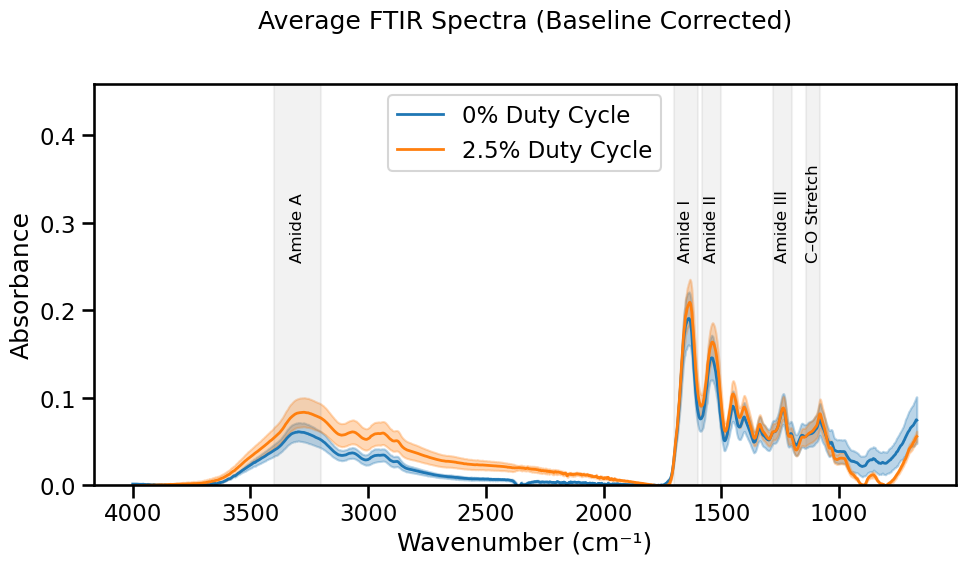

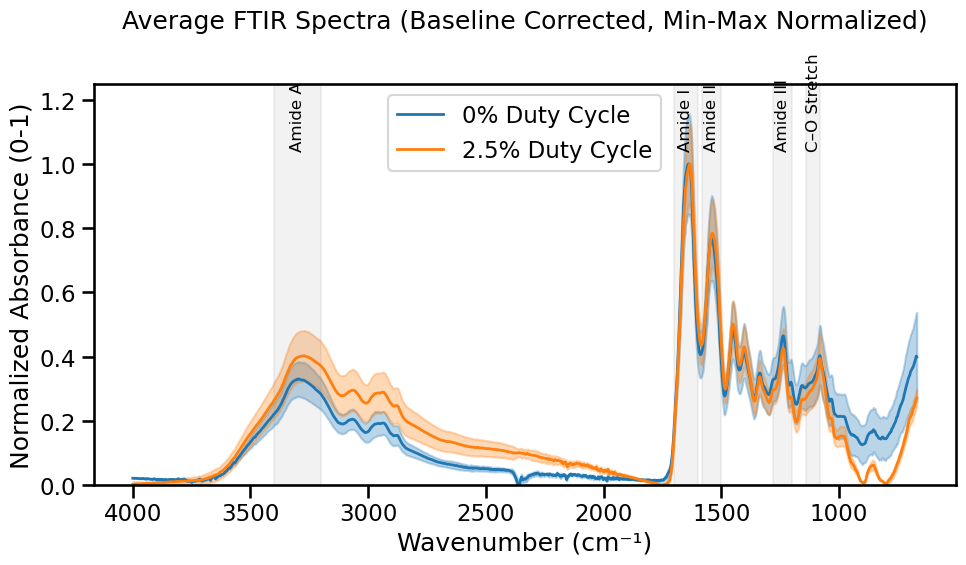

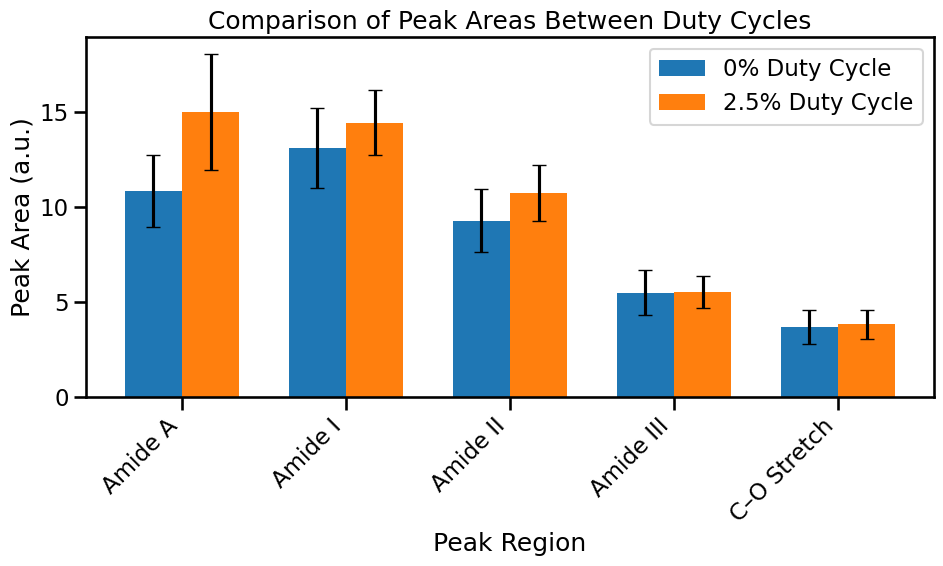

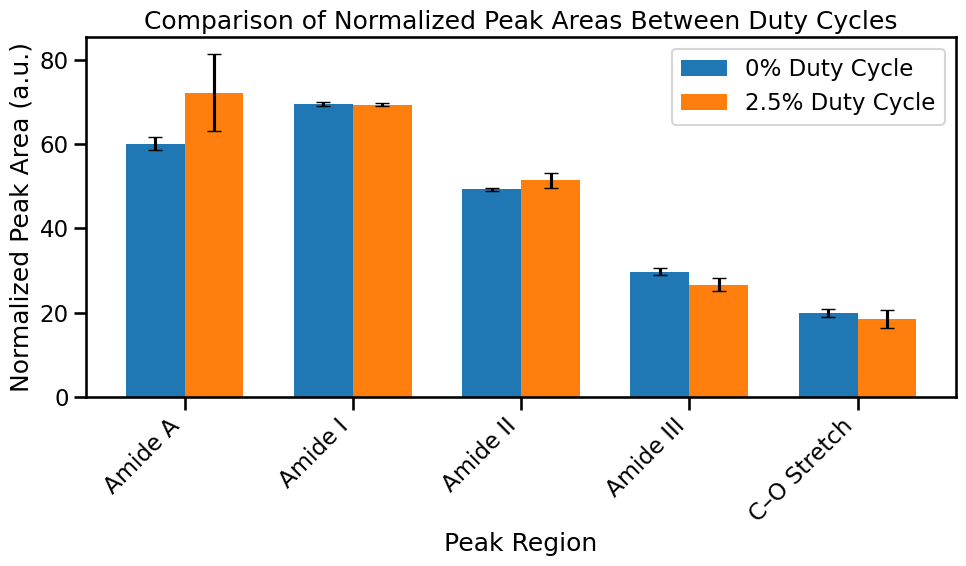

In [47]:
color_0 = '#1f77b4'  # Blue for 0% duty cycle
color_25 = '#ff7f0e'  # Orange for 2.5% duty cycle

# Function to normalize data to 0-1 range
def min_max_normalize(data):
    return (data - data.min()) / (data.max() - data.min())

# Function to compute mean spectra
def compute_mean_spectra(spectra):
    if len(spectra) == 0:
        raise ValueError("No spectra to compute mean from")
    wavenumbers = spectra[0]['Wavenumber'].values
    absorbances = np.array([s['Absorbance'].values for s in spectra])
    return wavenumbers, absorbances.mean(axis=0), absorbances.std(axis=0)

# Compute mean and std for both groups
wave_0, mean_0, std_0 = compute_mean_spectra(spectra_0)
wave_25, mean_25, std_25 = compute_mean_spectra(spectra_25)

# Define peak regions for annotation
regions = {
    'Amide A': (3200, 3400), 
    'Amide I': (1600, 1700),
    'Amide II': (1500, 1580), 
    'Amide III': (1200, 1280),
    'C–O Stretch': (1080, 1140)
}

# Function to calculate area under curve for a given region
def calculate_area(wavenumbers, absorbances, start, end):
    mask = (wavenumbers >= start) & (wavenumbers <= end)
    return np.trapz(absorbances[mask], wavenumbers[mask])

# Calculate areas for each spectrum individually to get mean and std
areas_0_all = {label: [] for label in regions.keys()}
areas_25_all = {label: [] for label in regions.keys()}

# Calculate areas for each individual spectrum
for spectrum in spectra_0:
    wave = spectrum['Wavenumber'].values
    absorb = spectrum['Absorbance'].values
    for label, (start, end) in regions.items():
        areas_0_all[label].append(calculate_area(wave, absorb, start, end))

for spectrum in spectra_25:
    wave = spectrum['Wavenumber'].values
    absorb = spectrum['Absorbance'].values
    for label, (start, end) in regions.items():
        areas_25_all[label].append(calculate_area(wave, absorb, start, end))

# Calculate mean and std for areas
areas_0_mean = {label: np.mean(areas) for label, areas in areas_0_all.items()}
areas_0_std = {label: np.std(areas) for label, areas in areas_0_all.items()}
areas_25_mean = {label: np.mean(areas) for label, areas in areas_25_all.items()}
areas_25_std = {label: np.std(areas) for label, areas in areas_25_all.items()}

# Also calculate normalized areas for each spectrum
areas_0_norm_all = {label: [] for label in regions.keys()}
areas_25_norm_all = {label: [] for label in regions.keys()}

for spectrum in spectra_0:
    wave = spectrum['Wavenumber'].values
    absorb = min_max_normalize(spectrum['Absorbance'].values)
    for label, (start, end) in regions.items():
        areas_0_norm_all[label].append(calculate_area(wave, absorb, start, end))

for spectrum in spectra_25:
    wave = spectrum['Wavenumber'].values
    absorb = min_max_normalize(spectrum['Absorbance'].values)
    for label, (start, end) in regions.items():
        areas_25_norm_all[label].append(calculate_area(wave, absorb, start, end))

# Calculate mean and std for normalized areas
areas_0_norm_mean = {label: np.mean(areas) for label, areas in areas_0_norm_all.items()}
areas_0_norm_std = {label: np.std(areas) for label, areas in areas_0_norm_all.items()}
areas_25_norm_mean = {label: np.mean(areas) for label, areas in areas_25_norm_all.items()}
areas_25_norm_std = {label: np.std(areas) for label, areas in areas_25_norm_all.items()}

# ========== PLOT 1: RAW ABSORBANCE ==========
sns.set_context("talk")
plt.figure(figsize=(10, 6))

# Plot mean spectra with std as shaded regions
plt.plot(wave_0, mean_0, color=color_0, label='0% Duty Cycle', linewidth=2)
plt.fill_between(wave_0, mean_0 - std_0, mean_0 + std_0, alpha=0.3, color=color_0)

plt.plot(wave_25, mean_25, color=color_25, label='2.5% Duty Cycle', linewidth=2)
plt.fill_between(wave_25, mean_25 - std_25, mean_25 + std_25, alpha=0.3, color=color_25)

# Add peak annotations
y_max = max(mean_0.max(), mean_25.max())
for label, (start, end) in regions.items():
    mid = (start + end) / 2
    plt.axvspan(start, end, color='gray', alpha=0.1)
    plt.text(mid, y_max + 0.05, label, ha='center', rotation=90, fontsize=12)

# Format the plot
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Absorbance')
plt.title('Average FTIR Spectra (Baseline Corrected)', pad=40)
plt.ylim(0, y_max + 0.25)
plt.gca().invert_xaxis()  # FTIR convention
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# ========== PLOT 2: MIN-MAX NORMALIZED ==========
# Normalize the mean spectra
mean_0_norm = min_max_normalize(mean_0)
mean_25_norm = min_max_normalize(mean_25)

# Also normalize the standard deviations proportionally
std_0_norm = std_0 / (mean_0.max() - mean_0.min())
std_25_norm = std_25 / (mean_25.max() - mean_25.min())

# Create the normalized plot
plt.figure(figsize=(10, 6))

# Plot normalized mean spectra with std as shaded regions
plt.plot(wave_0, mean_0_norm, color=color_0, label='0% Duty Cycle', linewidth=2)
plt.fill_between(wave_0, mean_0_norm - std_0_norm, mean_0_norm + std_0_norm, alpha=0.3, color=color_0)

plt.plot(wave_25, mean_25_norm, color=color_25, label='2.5% Duty Cycle', linewidth=2)
plt.fill_between(wave_25, mean_25_norm - std_25_norm, mean_25_norm + std_25_norm, alpha=0.3, color=color_25)

# Add peak annotations
y_max = max(mean_0_norm.max(), mean_25_norm.max())
for label, (start, end) in regions.items():
    mid = (start + end) / 2
    plt.axvspan(start, end, color='gray', alpha=0.1)
    plt.text(mid, y_max + 0.05, label, ha='center', rotation=90, fontsize=12)

# Format the plot
plt.xlabel('Wavenumber (cm⁻¹)')
plt.ylabel('Normalized Absorbance (0-1)')
plt.title('Average FTIR Spectra (Baseline Corrected, Min-Max Normalized)', pad=40)
plt.ylim(0, y_max + 0.25)
plt.gca().invert_xaxis()  # FTIR convention
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

# ========== PLOT 3: BAR CHART OF PEAK AREAS ==========
# Prepare data for bar chart
region_labels = list(regions.keys())
x = np.arange(len(region_labels))  # label locations
width = 0.35  # width of bars

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [areas_0_mean[label] for label in region_labels], 
                width, yerr=[areas_0_std[label] for label in region_labels],
                label='0% Duty Cycle', color=color_0, capsize=5)
bars2 = ax.bar(x + width/2, [areas_25_mean[label] for label in region_labels], 
                width, yerr=[areas_25_std[label] for label in region_labels],
                label='2.5% Duty Cycle', color=color_25, capsize=5)

# Add labels and formatting
ax.set_xlabel('Peak Region')
ax.set_ylabel('Peak Area (a.u.)')
ax.set_title('Comparison of Peak Areas Between Duty Cycles')
ax.set_xticks(x)
ax.set_xticklabels(region_labels, rotation=45, ha='right')
ax.legend()

plt.grid(False)
plt.tight_layout()
plt.show()

# ========== PLOT 4: NORMALIZED BAR CHART ==========
# Create normalized bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, [areas_0_norm_mean[label] for label in region_labels], 
                width, yerr=[areas_0_norm_std[label] for label in region_labels],
                label='0% Duty Cycle', color=color_0, capsize=5)
bars2 = ax.bar(x + width/2, [areas_25_norm_mean[label] for label in region_labels], 
                width, yerr=[areas_25_norm_std[label] for label in region_labels],
                label='2.5% Duty Cycle', color=color_25, capsize=5)

# Add labels and formatting
ax.set_xlabel('Peak Region')
ax.set_ylabel('Normalized Peak Area (a.u.)')
ax.set_title('Comparison of Normalized Peak Areas Between Duty Cycles')
ax.set_xticks(x)
ax.set_xticklabels(region_labels, rotation=45, ha='right')
ax.legend()

plt.grid(False)
plt.tight_layout()
plt.show()